In [2]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import Monit
from utils import CONSTANTS
import os, sys

15:40:06 ( +665.1s) [INFO   ] -- import logging
15:40:06 (    +2ms) [INFO   ] -- import numpy as np
15:40:06 (    +7ms) [INFO   ] -- import uncertainties
15:40:06 (    +2ms) [INFO   ] -- import numpy as np
15:40:06 (    +7ms) [INFO   ] -- import uncertainties
15:40:06 (  +226ms) [INFO   ] -- import pandas as pd
15:40:06 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
15:40:06 (    +1ms) [INFO   ] -- import binaries.tools as tools
15:40:07 (  +330ms) [INFO   ] -- import matplotlib.pyplot as plt
15:40:07 (  +423ms) [INFO   ] -- import seaborn as so
15:40:07 (    +1ms) [INFO   ] -- import plotting.tools as plot
15:40:07 (    +7ms) [DEBUG  ] -- font size set to 9.5
15:40:07 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:40:07 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:40:07 (    +0ms) [DEBUG  ] -- markersize set to 2.0
15:40:07 (    +1ms) [DEBUG  ] -- usetex set to False


In [3]:
version = 'v42'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [f"{base}/{f}" for f in os.listdir(base) if f.startswith('mc')]

muonfill = np.loadtxt(f"{base}/calib.test")
trigger2 = Monit(*monit_files)

15:40:11 (   +4.0s) [INFO   ] -- received 2 file(s) as input
15:40:11 (  +240ms) [INFO   ] -- View monit keys with self.keys()


In [67]:
def pair_indices(ti, tj) -> dict:
    return {i : np.argmin(np.abs(i - tj)) for i in ti}

t_muonfill = muonfill[:, 0] + CONSTANTS.GPS_OFFSET
t_trigger2 = trigger2('fTime', 609)

pairs = pair_indices(t_muonfill, t_trigger2)
vems_trigger2 = trigger2('fPeak', 609) * 1.42
vems_muonfill = muonfill[:, 1:-2:2]

ratios = (vems_muonfill / np.array([vems_trigger2[pairs[t]] for t in t_muonfill])).T

def ssd_chi2_minimization(version: str, X: np.ndarray) -> np.ndarray:
    t, mip, err = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', unpack=True)

    idx = [np.argmin(np.abs(tx - t_muonfill)) for tx in t]
    chi2 = np.zeros_like(X)

    for i, x in enumerate(X):
        chi2[i] = np.sum( (x*muonfill[:, -2][idx] - mip)**2/err**2 )

    return chi2

scale_ssd = np.linspace(1.23, 1.26, 10000)
chi2_ssd = ssd_chi2_minimization(version, scale_ssd)

16:52:52 ( +136.3s) [INFO   ] -- found 226 entries for key fTime and station #609
16:52:52 (   +27ms) [INFO   ] -- found 226 entries for key fPeak and station #609


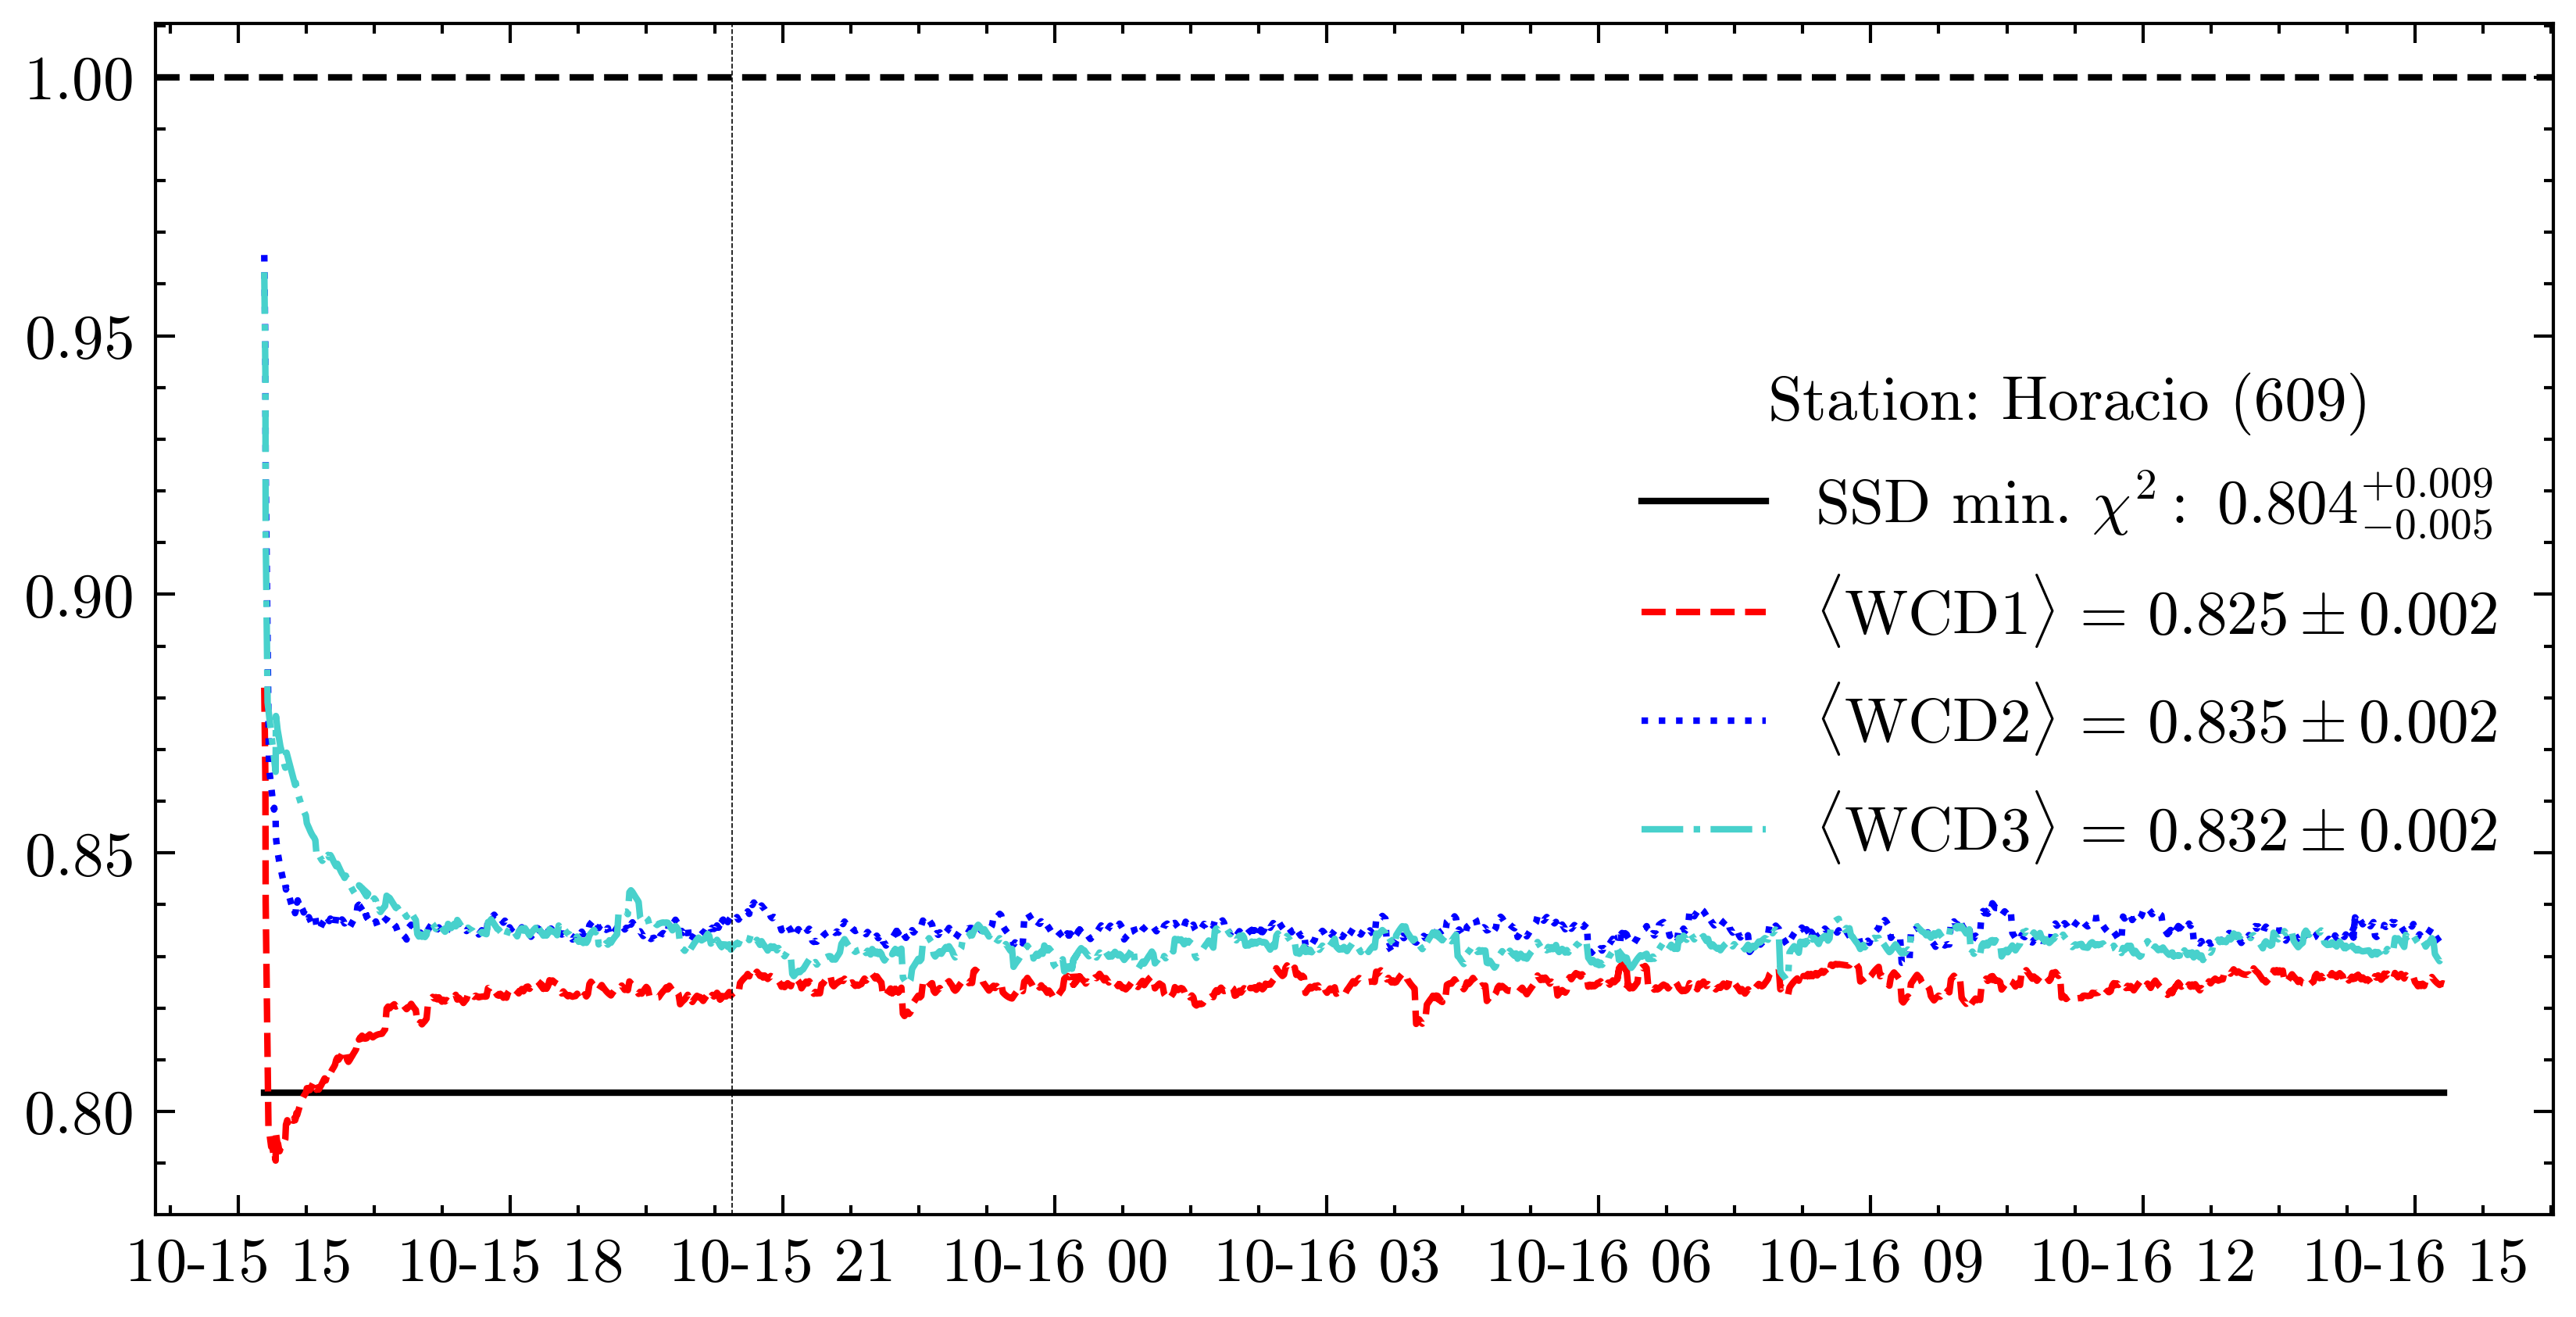

In [72]:
colors = ['r', 'b', 'mediumturquoise']
labels = ['WCD1', 'WCD2', 'WCD3']

min_chi2 = np.argmin(chi2_ssd)
pos_err = scale_ssd[np.argmin(np.abs(chi2_ssd[min_chi2] + 0.5 - chi2_ssd[min_chi2:]))] - scale_ssd[min_chi2]
neg_err = scale_ssd[min_chi2] - scale_ssd[np.argmin(np.abs(chi2_ssd[min_chi2] + 0.5 - chi2_ssd[:min_chi2]))]
plt.plot(plot.to_datetime([t_muonfill[0], t_muonfill[-1]]), [1/scale_ssd[min_chi2] for _ in range(2)], 
         label=rf'SSD min. $\chi^2:\ {1/scale_ssd[min_chi2]:.3f}^{{+{-pos_err:.3f}}}_{{{-neg_err:.3f}}}$')

skip = 400
for r, c, l in zip(ratios, colors, labels):
    m, s = np.mean(r[skip:]), np.std(r[skip:])
    plt.plot(plot.to_datetime(t_muonfill), r, c=c, label=rf'$\langle\mathrm{{{l}}}\rangle\,=\,{m:.3f}\pm{s:.3f}$')

plt.legend(title='Station: Horacio (609)')
plt.axvline(plot.to_datetime(t_muonfill[skip]), c='k', lw=0.2, ls='--')
plt.axhline(1, c='k', ls='--')